In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Logistic_Regression():

  def train_dev_split(self,X,Y,train_size):
    m=int(train_size*X.shape[0])
    X_train=X[:m,:]
    X_dev=X[m:,:]
    Y_train=Y[:m]
    Y_dev=Y[m:]
    return X_train,Y_train,X_dev,Y_dev

  def Z_score_standardize(self,X,X_train_):
    Mean=np.mean(X_train_,axis=0)
    std=np.std(X_train_,axis=0)
    std[std==0]=1
    return (X-Mean)/std

  def min_max_normalize(self,X,X_train_):
    Min=np.min(X_train_,axis=0)
    Max=np.max(X_train_,axis=0)
    Range=Max-Min
    Range[Range==0]=1
    return (X-Min)/Range

  def Batch_GD(self,X_train,Y_train,iterations=100,learning_rate=0.5,L2_regularization_term=0,Exp_learning_rate_decay=None,Feature_Scaling="Z_score_standardization",validation=False,X_dev=np.array([]),Y_dev=np.array([])):
    self.validation=validation
    self.iterations=iterations
    alpha=learning_rate
    alpha1=alpha
    lamda=L2_regularization_term
    X_train_=np.copy(X_train)
    if Feature_Scaling=="Z_score_standardization":
      self.X_train_n=self.Z_score_standardize(X_train,X_train_)
    elif Feature_Scaling=="min_max_normalization":
      self.X_train_n=self.min_max_normalize(X_train,X_train_)
    else:
      self.X_train_n=X_train
    self.Y_train=Y_train.reshape(-1,1)
    m_train,n_train=X_train.shape
    O_train=self.one_hot(self.Y_train)
    self.w=np.random.randn(n_train,10)/np.sqrt(n_train)
    self.b=np.random.randn(1,10)
    self.J_train_list=[]
    self.train_accuracy=[]
    if self.validation:
      if X_dev.size>0 and Y_dev.size>0:
        self.Y_dev=Y_dev.reshape(-1,1)
        O_dev=self.one_hot(self.Y_dev)
        self.J_dev_list=[]
        self.dev_accuracy=[]
        if Feature_Scaling=="Z_score_standardization":
          self.X_dev_n=self.Z_score_standardize(X_dev,X_train_)
        elif Feature_Scaling=="min_max_normalization":
          self.X_dev_n=self.min_max_normalize(X_dev,X_train_)
        else:
          self.X_dev_n=X_dev
      else:
        print("Enter validation data in function call")
        return
    for i in range(iterations):
      Z_train=self.weighted_inputs(self.X_train_n)
      A_train=self.sigmoid(Z_train)
      self.J_train_list.append(self.Binary_Cross_Entropy(O_train,A_train))
      self.train_accuracy.append(self.accuracy(self.Y_train,Z_train))
      if self.validation:
        Z_dev=self.weighted_inputs(self.X_dev_n)
        A_dev=self.sigmoid(Z_dev)
        self.J_dev_list.append(self.Binary_Cross_Entropy(O_dev,A_dev))  
        self.dev_accuracy.append(self.accuracy(self.Y_dev,Z_dev))
      dw=(1/m_train)*(self.X_train_n.T@(A_train-O_train))+((lamda/m_train)*self.w)
      db=(1/m_train)*(np.sum(A_train-O_train))
      self.w-=alpha*dw
      self.b-=alpha*db
      if Exp_learning_rate_decay and i%10==0:
        alpha=(Exp_learning_rate_decay**(i/10))*alpha1

    Z_train=self.weighted_inputs(self.X_train_n)
    A_train=self.sigmoid(Z_train)
    self.J_train_list.append(self.Binary_Cross_Entropy(O_train,A_train))
    self.train_accuracy.append(self.accuracy(self.Y_train,Z_train))

    if self.validation:
      Z_dev=self.weighted_inputs(self.X_dev_n)
      A_dev=self.sigmoid(Z_dev)
      self.J_dev_list.append(self.Binary_Cross_Entropy(O_dev,A_dev))  
      self.dev_accuracy.append(self.accuracy(self.Y_dev,Z_dev))
      

  def mini_batch_GD(self,X_train,Y_train,epochs=100,learning_rate=0.5,L2_regularization_term=0,Exp_learning_rate_decay=None,mini_batch_size=10,Feature_Scaling="Z_score_standardization",validation=False,X_dev=np.array([]),Y_dev=np.array([])):
    self.mini_batch_size=mini_batch_size
    self.validation=validation
    self.iterations=epochs
    self.alpha=learning_rate
    alpha1=self.alpha
    self.lamda=L2_regularization_term
    X_train_=np.copy(X_train)
    if Feature_Scaling=="Z_score_standardization":
      self.X_train_n=self.Z_score_standardize(X_train,X_train_)
    elif Feature_Scaling=="min_max_normalization":
      self.X_train_n=self.min_max_normalize(X_train,X_train_)
    else:
      self.X_train_n=X_train
    self.Y_train=Y_train.reshape(-1,1)
    self.m_train,self.n_train=X_train.shape
    O_train=self.one_hot(self.Y_train)
    self.w=np.random.randn(self.n_train,10)/np.sqrt(self.n_train)
    self.b=np.random.randn(1,10)
    self.J_train_list=[]
    self.train_accuracy=[]
    if self.validation:
      if X_dev.size>0 and Y_dev.size>0:
        self.Y_dev=Y_dev.reshape(-1,1)
        O_dev=self.one_hot(self.Y_dev)
        self.J_dev_list=[]
        self.dev_accuracy=[]
        if Feature_Scaling=="Z_score_standardization":
          self.X_dev_n=self.Z_score_standardize(X_dev,X_train_)
        elif Feature_Scaling=="min_max_normalization":
          self.X_dev_n=self.min_max_normalize(X_dev,X_train_)
        else:
          self.X_dev_n=X_dev
      else:
        print("Enter validation data in function call")
        return
    train_data=np.append(self.X_train_n,O_train,axis=1)
    for i in range(epochs):
      Z_train=self.weighted_inputs(self.X_train_n)
      A_train=self.sigmoid(Z_train)
      self.J_train_list.append(self.Binary_Cross_Entropy(O_train,A_train))
      self.train_accuracy.append(self.accuracy(self.Y_train,Z_train))
      if self.validation:
        Z_dev=self.weighted_inputs(self.X_dev_n)
        A_dev=self.sigmoid(Z_dev)
        self.J_dev_list.append(self.Binary_Cross_Entropy(O_dev,A_dev))  
        self.dev_accuracy.append(self.accuracy(self.Y_dev,Z_dev))
      np.random.shuffle(train_data)
      mini_batch_list=[train_data[k:k+mini_batch_size,:] for k in (0,self.m_train,mini_batch_size)]
      for mini_batch in mini_batch_list:
        self.mini_batch_update(mini_batch)
      if Exp_learning_rate_decay:
        alpha=(Exp_learning_rate_decay**(i))*alpha1
      
    Z_train=self.weighted_inputs(self.X_train_n)
    A_train=self.sigmoid(Z_train)
    self.J_train_list.append(self.Binary_Cross_Entropy(O_train,A_train))
    self.train_accuracy.append(self.accuracy(self.Y_train,Z_train))
    if self.validation:
      Z_dev=self.weighted_inputs(self.X_dev_n)
      A_dev=self.sigmoid(Z_dev)
      self.J_dev_list.append(self.Binary_Cross_Entropy(O_dev,A_dev))  
      self.dev_accuracy.append(self.accuracy(self.Y_dev,Z_dev))
  
  def mini_batch_update(self,mini_batch):
    x=mini_batch[:,:self.n_train]
    o=mini_batch[:,self.n_train:]
    z=self.weighted_inputs(x)
    a=self.sigmoid(z)
    dw=(1/self.mini_batch_size)*(x.T@(a-o))+(self.lamda/self.m_train*self.w)
    db=(1/self.mini_batch_size)*(np.sum(a-o))
    self.w-=self.alpha*dw
    self.b-=self.alpha*db
     
  def Results(self,Cost_learning_curve=True,Accuracy_learning_curve=True,Table_showing_predicted_vs_actual=True):
    li=np.arange(0,self.iterations+1)
    if Cost_learning_curve:
      print("Final Cost of training data is: ",self.J_train_list[-1],"\n")
      if self.validation:
        print("Final Cost of dev data is: ",self.J_dev_list[-1],"\n")
      plt.plot(li,self.J_train_list,color="blue",label="Training Cost")
      if self.validation:
        plt.plot(li,self.J_dev_list,color="Red",label="Dev cost")
      plt.xlabel("Epochs")
      plt.ylabel("Cost")
      plt.title("Cost vs Iterations curve")
      plt.legend()
      plt.show()
      print("\n")
   
    if Accuracy_learning_curve:
      print("Final Accuracy of training data is: ",self.train_accuracy[-1],"%")
      print("\n")
      if self.validation:
        print("Final Accuracy of dev data is: ",self.dev_accuracy[-1],"%")
        print("\n")
      plt.plot(li,self.train_accuracy,color="blue",label="Train")
      if self.validation:
        plt.plot(li,self.dev_accuracy,color="Red",label="Dev")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.title("Accuracy vs Epochs curve")
      plt.legend()
      plt.show()
      print("\n")

    if Table_showing_predicted_vs_actual:
      train_table=np.append(self.Y_train[:20,:],self.predict(self.X_train_n).reshape(-1,1)[:20,:],axis=1)
      df=pd.DataFrame(train_table,columns=["Actual","Predicted"])
      print("A table showing predicted labels and actual label for the first 20 examples of training data: ")
      print(df)
      print("\n")

      if self.validation:
        train_table=np.append(self.Y_dev[:20,:],self.predict(self.X_dev_n).reshape(-1,1)[:20,:],axis=1)
        df=pd.DataFrame(train_table,columns=["Actual","Predicted"])
        print("A table showing predicted labels and actual label for the first 20 examples of dev data: ")
        print(df)

  def accuracy(self,y,z):
    y=y.flatten()
    return (np.sum(np.argmax(z,axis=1)==y)/y.shape[0])*100

  def Binary_Cross_Entropy(self,o,a):
    return (1/o.shape[0])*np.sum(np.nan_to_num((-o*np.log(a))-((1-o)*np.log(1-a))))

  def weighted_inputs(self,x):
    return (x@self.w+self.b)

  def sigmoid(self,z):
    return (1/(1+np.exp(-z)))

  def one_hot(self,Y):
    Y=Y.flatten()
    O=np.zeros((Y.shape[0],10))
    O[np.arange(Y.shape[0]),Y]=1
    return O

  def predict(self,X_test):
    Z_test=self.weighted_inputs(X_test)
    Y_pred=np.argmax(Z_test,axis=1)
    return Y_pred
   



In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Woc/classification_train.csv")
df_arr=np.array(df)
X=df_arr[:,2:]
Y=df_arr[:,1]

In [ ]:
Model=Logistic_Regression()
X_train,Y_train,X_dev,Y_dev=Model.train_dev_split(X,Y,0.8)

Final Cost of training data is:  0.9618382692696313 

Final Cost of dev data is:  0.9841647389876375 



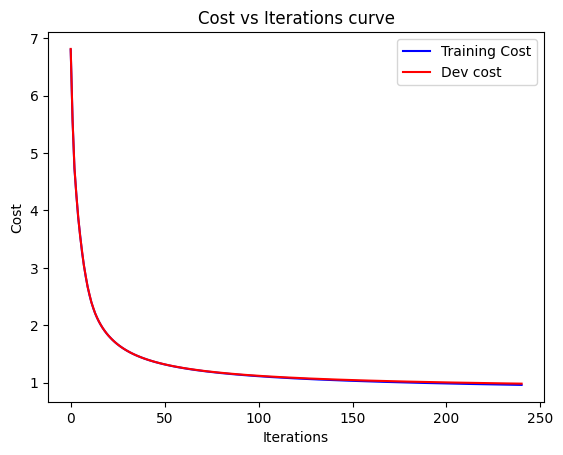



Final Accuracy of training data is:  83.32083333333333 %


Final Accuracy of dev data is:  82.93333333333334 %




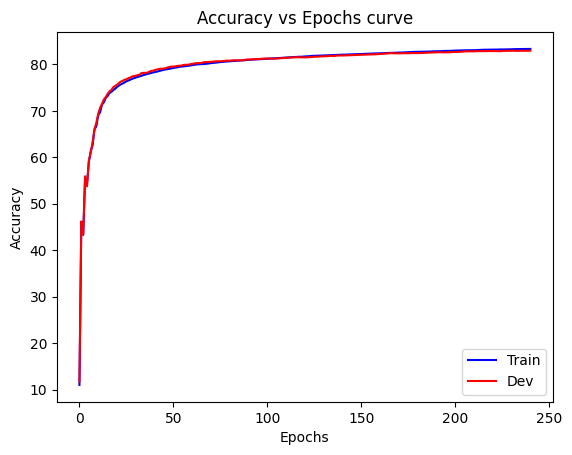



A table showing predicted labels and actual label for the first 20 examples of training data: 
    Actual  Predicted
0        8          7
1        4          4
2        1          1
3        8          8
4        2          2
5        0          0
6        7          7
7        4          4
8        1          1
9        7          7
10       9          9
11       0          0
12       1          1
13       7          7
14       2          4
15       3          0
16       2          4
17       3          3
18       4          4
19       8          8


A table showing predicted labels and actual label for the first 20 examples of dev data: 
    Actual  Predicted
0        4          6
1        0          0
2        1          1
3        1          1
4        6          6
5        6          4
6        2          2
7        4          4
8        4          4
9        2          2
10       4          4
11       6          6
12       4          4
13       0          0
14       5         

In [ ]:
Model.Batch_GD(X_train,Y_train,iterations=240,learning_rate=0.06,L2_regularization_term=0,Exp_learning_rate_decay=None,Feature_Scaling="Z_score_standardization",validation=True,X_dev=X_dev,Y_dev=Y_dev)
Model.Results()

Final Cost of training data is:  7.705593561643039 

Final Cost of dev data is:  7.718328871133193 



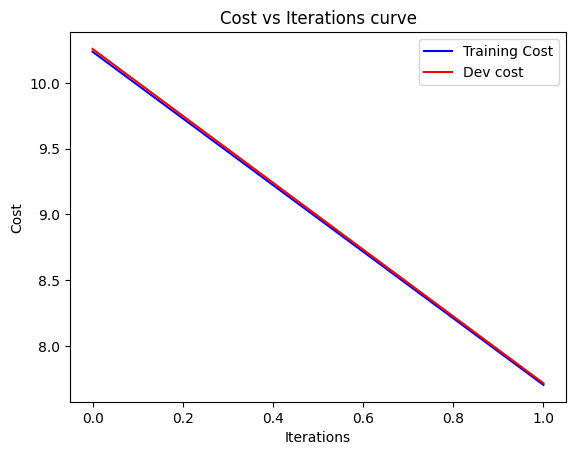



Final Accuracy of training data is:  23.916666666666668 %


Final Accuracy of dev data is:  23.7 %




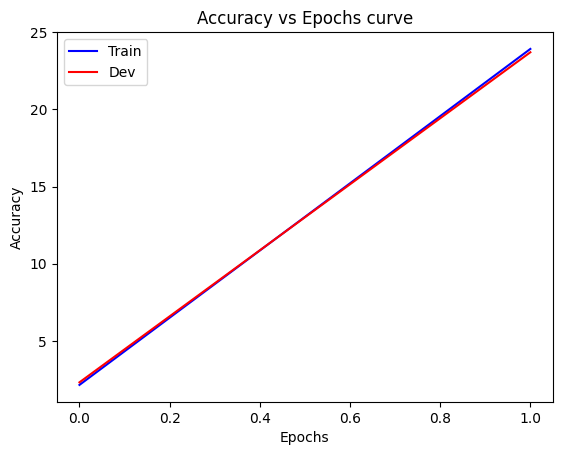



A table showing predicted labels and actual label for the first 20 examples of training data: 
    Actual  Predicted
0        8          9
1        4          4
2        1          4
3        8          4
4        2          4
5        0          9
6        7          9
7        4          4
8        1          4
9        7          9
10       9          9
11       0          9
12       1          4
13       7          9
14       2          4
15       3          6
16       2          4
17       3          4
18       4          9
19       8          4


A table showing predicted labels and actual label for the first 20 examples of dev data: 
    Actual  Predicted
0        4          6
1        0          2
2        1          4
3        1          9
4        6          4
5        6          9
6        2          4
7        4          4
8        4          4
9        2          4
10       4          2
11       6          4
12       4          4
13       0          4
14       5         

In [ ]:
Model.mini_batch_GD(X_train,Y_train,epochs=1,learning_rate=0.03,L2_regularization_term=0,Exp_learning_rate_decay=0.8,mini_batch_size=100,Feature_Scaling="Z_score_standardization",validation=True,X_dev=X_dev,Y_dev=Y_dev)
Model.Results()

In [ ]:
0.95**1000*0.01

5.2918227477448005e-25

In [ ]:
Model.J_train_list

[9.528801988582721,
 7.662346339951887,
 6.288240090962065,
 5.4335291980213976,
 4.75911223136242,
 4.359686442829347,
 4.005282409951267,
 3.582358910407928,
 3.323308320444441,
 3.083232940788711,
 2.9163179254637086,
 2.7639922405336423,
 2.5979971504061887,
 2.5154708792859433,
 2.4112836705293645,
 2.3138812841288185,
 2.2367060555859566,
 2.181405381917014,
 2.101686120247091,
 2.0318010899660837,
 1.9878734444593944,
 1.938524170385309,
 1.889871316682299,
 1.8351788061035346,
 1.8062864078673273,
 1.7780911086417672,
 1.7486915275634791,
 1.7150677647988497,
 1.6905642630457216,
 1.6704239155346288,
 1.6324646974086088,
 1.6234554174527789,
 1.6045760564999094,
 1.5897930039033905,
 1.5586521147821222,
 1.5412296153782281,
 1.522182050176771,
 1.5149278698624844,
 1.4933046750460637,
 1.4773650664967253,
 1.464059380244282,
 1.454695378338987,
 1.444329184485438,
 1.4325097362676942,
 1.4209708308395252,
 1.4072778265235895,
 1.4001891563928448,
 1.3908820311474859,
 1.3845166